In [121]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.utils import resample
import stability as st

from sklearn.linear_model import LinearRegression

pd.DataFrame.iteritems=pd.DataFrame.items
import catboost
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import Ridge, Lasso


from scipy import stats

import seaborn as sns 
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings


import optuna


from prophet import Prophet
from prophet.diagnostics import cross_validation

In [ ]:
!pip freeze -> requirements.txt

## EDA

In [2]:
data = pd.read_excel('Project 1_2024.xlsx', sheet_name=0)

In [3]:
data

,Date,Income,Outcome,Balance
0,2017-01-09 00:00:00.000,1.343028,1.487865,-0.155904
1,2017-01-10 00:00:00.000,1.068610,1.194182,-0.125572
2,2017-01-11 00:00:00.000,0.944429,0.936663,0.007767
3,2017-01-12 00:00:00.000,1.672202,0.875379,0.800391
4,2017-01-13 00:00:00.000,0.955924,0.975645,-0.019721
...,...,...,...,...
1538,2021-03-27 00:00:00.000,0.000000,0.000000,0.000000
1539,2021-03-28 00:00:00.000,0.000000,0.000000,0.000000
1540,2021-03-29 00:00:00.000,2.356883,3.370738,-1.017679
1541,2021-03-30 00:00:00.000,2.317382,2.567554,-0.259687


In [4]:
print(f"min date: {data['Date'].min()}")
print(f"max date: {data['Date'].max()}")
print(f"total num days: {data.shape[0]}")


min date: 2017-01-09 00:00:00.000
max date: 2021-03-31 00:00:00.000
total num days: 1543


In [5]:
print(f"min balance: {data['Balance'].min()}")
print(f"max balance: {data['Balance'].max()}")
print(f"median balance: {data['Balance'].median()}")

min balance: -2.514886598357007
max balance: 1.4088631729015693
median balance: 0.0


## Add features

### macro features

In [6]:
data['Date_short'] =  data['Date'].apply(lambda x: x[:7])

In [7]:
macro_data1 = pd.read_excel('/Users/veronikayashina/Desktop/мага/временные ряды/project 1/Инфляция и ключевая ставка Банка России_F27_07_2013_T23_01_2023.xlsx'
                            , sheet_name=0, converters={'Дата': str})\
                            .rename(columns={'Ключевая ставка, % годовых': 'key_rate', 'Инфляция, % г/г': 'infl_rate'})
macro_data1['Date_short'] = macro_data1['Дата'].apply(lambda x: x.split('.')[1]+'-'+ x.split('.')[0] if len(x.split('.')[0]) == 2 else x.split('.')[1]+'-0'+ x.split('.')[0])

In [8]:
data_with_macro= data.merge(macro_data1.drop(['Дата', 'Цель по инфляции'], axis=1), on='Date_short', how='left')


In [9]:
data_with_macro.isnull().sum()

Date          0
Income        0
Outcome       0
Balance       0
Date_short    0
key_rate      0
infl_rate     0
dtype: int64

### taxes 

In [10]:
data_with_macro['day']= data_with_macro['Date'].apply(lambda x: int(x[8:10]))

In [11]:
data_with_macro['tax_day'] = 0
data_with_macro.loc[data_with_macro['day'] == 28, 'tax_day'] = 1

In [12]:
data_with_macro

,Date,Income,Outcome,Balance,Date_short,key_rate,infl_rate,day,tax_day
0,2017-01-09 00:00:00.000,1.343028,1.487865,-0.155904,2017-01,10.0,5.0,9,0
1,2017-01-10 00:00:00.000,1.068610,1.194182,-0.125572,2017-01,10.0,5.0,10,0
2,2017-01-11 00:00:00.000,0.944429,0.936663,0.007767,2017-01,10.0,5.0,11,0
3,2017-01-12 00:00:00.000,1.672202,0.875379,0.800391,2017-01,10.0,5.0,12,0
4,2017-01-13 00:00:00.000,0.955924,0.975645,-0.019721,2017-01,10.0,5.0,13,0
...,...,...,...,...,...,...,...,...,...
1538,2021-03-27 00:00:00.000,0.000000,0.000000,0.000000,2021-03,4.5,5.8,27,0
1539,2021-03-28 00:00:00.000,0.000000,0.000000,0.000000,2021-03,4.5,5.8,28,1
1540,2021-03-29 00:00:00.000,2.356883,3.370738,-1.017679,2021-03,4.5,5.8,29,0
1541,2021-03-30 00:00:00.000,2.317382,2.567554,-0.259687,2021-03,4.5,5.8,30,0


## TSFresh

In [13]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient

{'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_values': None, 'sum_of_reoccurring_data_points': None, 'ratio_value_number_to_time_series_length': None, 'maximum': None, 'absolu

In [14]:
data_clean = data_with_macro.drop(['Date', 'Outcome', 'Income', 'Date_short', 'day', 'tax_day'], axis=1)

In [15]:
data_long = pd.DataFrame({0: data_clean.values.flatten(),
                          1: np.arange(data_clean.shape[0]).repeat(data_clean.shape[1])})
print(data_long.shape)
data_long.head()

(4629, 2)


,0,1
0,-0.155904,0
1,10.000000,0
2,5.000000,0
3,-0.125572,1
4,10.000000,1


In [16]:
X = extract_features(data_long, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


(1543, 777)


In [17]:
def primary_feature_filtering(df, nans_thrs = 0.5, std_thrs = 0):
    features = df.columns
    shape = df.shape[0]
    excluded_by_nans = []
    excluded_by_std = []

    for f in features:
        if df[f].isnull().sum() / shape > nans_thrs:
            excluded_by_nans.append(f)
        if df[f].std() <= std_thrs:
            excluded_by_std.append(f)

    clean_df = df.drop(excluded_by_std + excluded_by_nans, axis=1)
    print(f'Num cols excluded by null share: {len(excluded_by_nans)}')
    print(f'Num cols excluded by standard deviation: {len(excluded_by_std)}')
    print(f'Clean df shape: {clean_df.shape}')
    
    return excluded_by_nans, excluded_by_std, clean_df

In [18]:
excluded_by_nans, excluded_by_std, X_clean = primary_feature_filtering(X, nans_thrs = 0.5, std_thrs = 0.1)

Num cols excluded by null share: 0
Num cols excluded by standard deviation: 679
Clean df shape: (1543, 98)


In [19]:
X_clean

,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,0__mean,0__standard_deviation,0__variance,0__skewness,...,"0__linear_trend__attr_""stderr""",0__number_crossing_m__m_0,0__energy_ratio_by_chunks__num_segments_10__segment_focus_1,0__energy_ratio_by_chunks__num_segments_10__segment_focus_2,0__ratio_beyond_r_sigma__r_0.5,0__ratio_beyond_r_sigma__r_1,0__count_above__t_0,0__count_below__t_0,0__lempel_ziv_complexity__bins_3,0__lempel_ziv_complexity__bins_5
0,14.844096,125.024306,7.577952,2.577952,-7.577952,5.0,4.948032,4.146293,17.191747,-0.046046,...,4.375133,1.0,0.799844,0.199961,0.666667,0.666667,0.666667,0.333333,1.000000,1.000000
1,14.874428,125.015768,7.562786,2.562786,-7.562786,5.0,4.958143,4.133853,17.088745,-0.037201,...,4.366377,1.0,0.799899,0.199975,0.666667,0.666667,0.666667,0.333333,1.000000,1.000000
2,15.007767,125.000060,7.496117,2.496117,-7.496117,5.0,5.002589,4.079313,16.640791,0.002332,...,4.327885,0.0,0.800000,0.200000,0.666667,0.666667,1.000000,0.000000,1.000000,1.000000
3,15.800391,125.640625,7.099805,2.099805,-7.099805,5.0,5.266797,3.760460,14.141059,0.259805,...,4.099074,0.0,0.795921,0.198980,0.666667,0.666667,1.000000,0.000000,1.000000,1.000000
4,14.980279,125.000389,7.509861,2.509861,-7.509861,5.0,4.993426,4.090537,16.732490,-0.005905,...,4.335820,1.0,0.799998,0.199999,0.666667,0.666667,0.666667,0.333333,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,10.300000,53.890000,2.900000,2.900000,-1.600000,4.5,3.433333,2.485067,6.175556,-1.383386,...,0.923760,1.0,0.375765,0.624235,0.666667,0.333333,1.000000,0.333333,0.666667,1.000000
1539,10.300000,53.890000,2.900000,2.900000,-1.600000,4.5,3.433333,2.485067,6.175556,-1.383386,...,0.923760,1.0,0.375765,0.624235,0.666667,0.333333,1.000000,0.333333,0.666667,1.000000
1540,9.282321,54.925672,3.408840,3.408840,-2.108840,4.5,3.094107,2.955514,8.735060,-1.484124,...,1.217539,1.0,0.368680,0.612464,0.666667,0.333333,0.666667,0.333333,0.666667,0.666667
1541,10.040313,53.957437,3.029843,3.029843,-1.729843,4.5,3.346771,2.604791,6.784936,-1.414137,...,0.998726,1.0,0.375296,0.623454,0.666667,0.333333,0.666667,0.333333,0.666667,1.000000


## Baseline

In [20]:
X_clean['tax_day'] = data_with_macro['tax_day']
X_clean['date'] = data_with_macro['Date']
df_clean_with_target = X_clean.copy(deep=True)
df_clean_with_target['target'] = data_with_macro['Balance']

### intime/oot

In [21]:
X_clean['date'].min()

'2017-01-09 00:00:00.000'

In [22]:
X_clean['date'].max()

'2021-03-31 00:00:00.000'

In [23]:
oot_start = '2021-01-01'
intime_df = df_clean_with_target[df_clean_with_target['date'] < oot_start]#.drop('date_short', axis=1)
oot_df = df_clean_with_target[df_clean_with_target['date'] >= oot_start]#.drop('date_short', axis=1)

In [24]:
print(f'intime shape: {intime_df.shape}')
print(f'oot shape: {oot_df.shape}')

intime shape: (1453, 101)
oot shape: (90, 101)


In [25]:
X_train, X_val, y_train, y_val = train_test_split(intime_df.drop(['target', 'date'], axis=1), intime_df['target'], test_size=0.3, shuffle=False)

In [26]:
df_train_for_prophet, df_val_for_prophet, _, _ = train_test_split(intime_df, intime_df['target'], test_size=0.3, shuffle=False)
df_train_for_prophet = df_train_for_prophet.rename(columns={'date': 'ds', 'target': 'y'})
df_val_for_prophet = df_val_for_prophet.rename(columns={'date': 'ds', 'target': 'y'})

In [27]:
X_oot = oot_df.drop(['target', 'date'], axis=1)
y_oot = oot_df['target']

df_oot_for_prophet = oot_df.drop('target', axis=1).rename(columns={'date': 'ds'})

In [28]:
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_oot shape: {X_oot.shape}')

X_train shape: (1017, 99)
X_val shape: (436, 99)
X_oot shape: (90, 99)


In [29]:
lr=LinearRegression()
lr.fit(X_train, y_train)
print(f'train mae: {mean_absolute_error(y_train, lr.predict(X_train))}')
print(f'val mae: {mean_absolute_error(y_val, lr.predict(X_val))}')
print(f'test mae: {mean_absolute_error(y_oot, lr.predict(X_oot))}')

train mae: 2.0395743467825497e-15
val mae: 0.010541816128522336
test mae: 0.22862032029254553


## Stationarity checks & ARIMA

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


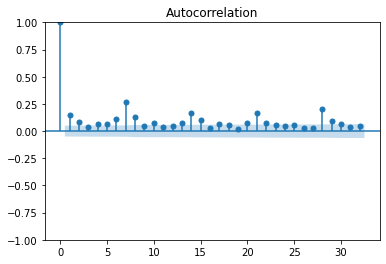

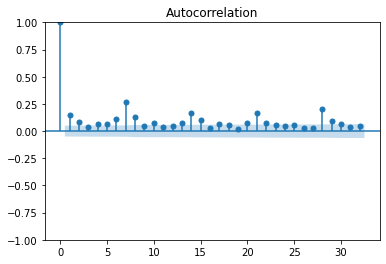

In [31]:
plot_acf(data['Balance'])

Полугодовая сезонность есть (видно по значимым лагам)

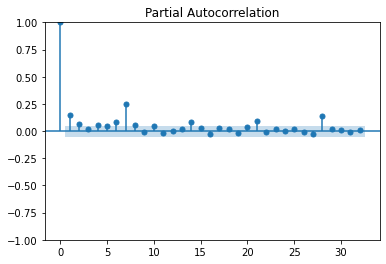

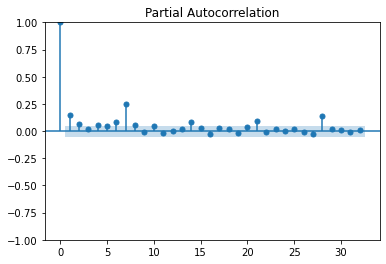

In [32]:
plot_pacf(data['Balance'])

Ряд вероятно не стационарен (по графикам), сделаем ADF test

In [33]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Balance'])
print(f'p-value: {adf_test[1]}')

p-value: 0.0009178315649530514


Тест отвергает нулевую гипотезу, что ряд нестационарен, значит можно делать авторегрессионную модель

In [34]:
import pmdarima as pm
auto_arima = pm.auto_arima(y_train, stepwise=True, seasonal=True, stationarity=True)
auto_arima

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
auto_arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1017
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -162.104
Date:                Sun, 14 Apr 2024   AIC                            330.209
Time:                        14:54:54   BIC                            344.979
Sample:                             0   HQIC                           335.818
                               - 1017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0592      0.028      2.089      0.037       0.004       0.115
ma.L1         -0.9657      0.009   -111.201      0.000      -0.983      -0.949
sigma2         0.0804      0.001     56.416      0.000       0.078       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5140.68
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
forecast_test_auto = auto_arima.predict(n_periods=len(y_oot))
mean_absolute_error(y_oot, forecast_test_auto)

0.3290250486526747

## Feature selection

In [37]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=100):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(intime_df.drop(columns=['date']), ))

Top Absolute Correlations
0__mean_second_derivative_central                  0__linear_trend__attr_"stderr"                                    1.000000
0__autocorrelation__lag_2                          0__agg_autocorrelation__f_agg_"mean"__maxlag_40                   1.000000
                                                   0__agg_autocorrelation__f_agg_"median"__maxlag_40                 1.000000
0__number_crossing_m__m_0                          0__count_below__t_0                                               1.000000
0__mean_change                                     0__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0    1.000000
                                                                                                                       ...   
0__agg_autocorrelation__f_agg_"median"__maxlag_40  0__energy_ratio_by_chunks__num_segments_10__segment_focus_2       0.995542
0__agg_autocorrelation__f_agg_"mean"__maxlag_40    0__energy_ratio_by_chunks__num_segments_1

In [38]:
def custom_feature_selection(df):
    # разделим таргет и признаки
    y = df['target']
    X = df.drop(columns=['target'])

    # сначала уберем признаки в соответствии с корреляцией
    au_corr = X.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    X_new = X.drop(columns=au_corr[au_corr > 0.99].index.get_level_values(0))

    # теперь применим Lasso
    lasso = Lasso(alpha=0.001)
    model = SelectFromModel(lasso)
    model.fit(X_new, y)

    X_new = pd.DataFrame(model.transform(X_new), columns=model.get_feature_names_out(), index=X_new.index)


    # применим RFE
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=5, step=1)
    selector = selector.fit(X_new, y)

    X_res = X_new[X_new.columns[selector.ranking_ == 1]]

    return X_res.columns

In [42]:
def correlation_between_features_selection(df, num_to_select=10):
    # оставим с помощью корреляции только три фактора 
    X = df.drop(columns=['target'])
    au_corr = X.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(X)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    # сначала сделаем грубое отсечение
    X_new = X.drop(columns=au_corr[au_corr > 0.9].index.get_level_values(0))

    # остальное доберем последовательно
    while len(X_new.columns) != num_to_select:
        X_new = X_new.drop(columns=get_top_abs_correlations(X_new, n=1).index.get_level_values(0))
    
    return X_new.columns


def correlation_between_features_and_target(df, corr_thr=0.5):
    # оставим с помощью корреляции только три фактора 
    X = df.drop(columns=['target'])
    y = df['target']
    cols_to_drop = []
    for col in X.columns:
        if X[col].corr(y) <= corr_thr:
            cols_to_drop.append(col)
    X_new = X.drop(cols_to_drop, axis=1)
    
    return X_new.columns


def rfe_selection(df, num_to_select=5):
    X = df.drop(columns=['target'])
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=num_to_select, step=1)
    selector = selector.fit(X, df['target'])

    return X.columns[selector.ranking_ == 1]


def lasso_selection(df, num_to_select=5):
    X = df.drop(columns=['target'])
    y = df['target']

    lasso = Lasso(alpha=0.0001)
    lasso.fit(X, y)

    return X.columns[np.abs(lasso.coef_).argsort().argsort() >= len(X.columns) - 3]

def catboost_selection(df, num_to_select=5):
    X = df.drop(columns=['target'])
    y = df['target']
    train_pool = Pool(X, y)
    ctb = CatBoostRegressor()
    summary = ctb.select_features(train_pool,num_features_to_select=num_to_select, features_for_select= ['0-98'],
                                  algorithm='RecursiveByShapValues', steps=2,
                train_final_model=True, logging_level = 'Silent')
    
    return X.filter(X.columns[summary["selected_features"]]).columns



In [43]:
def get_stability(df, method):
    tmp_res = method(resample(df, n_samples=1000))
    cols = np.ma.masked_where(df.columns.isin(tmp_res), df.columns, copy=True)._mask
    for i in range(2):
        tmp_res = method(resample(df, n_samples=1000))
        tmp_cols = np.ma.masked_where(df.columns.isin(tmp_res), df.columns, copy=True)._mask
        cols = np.vstack([cols, tmp_cols])
    return st.getStability(cols)

In [45]:
print('Custom Feature Selection Stability:', get_stability(intime_df.drop(columns=['date']), custom_feature_selection))
print('Features Correlation Selection Stability:', get_stability(intime_df.drop(columns=['date']), correlation_between_features_selection))
print('Correlation with Target Selection Stability:', get_stability(intime_df.drop(columns=['date']), correlation_between_features_and_target))
print('RFE Selection Stability:', get_stability(intime_df.drop(columns=['date']), rfe_selection))
print('Lasso Selection Stability:', get_stability(intime_df.drop(columns=['date']), lasso_selection))
print('Catboost Selection Stability:', get_stability(intime_df.drop(columns=['date']), catboost_selection))

Custom Feature Selection Stability: 0.8596491228070176
Features Correlation Selection Stability: 0.9259259259259259
Correlation with Target Selection Stability: 0.9339788732394366
RFE Selection Stability: 0.8596491228070176
Lasso Selection Stability: 0.7709049255441007


/Users/veronikayashina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.746e-02, tolerance: 6.887e-03
  model = cd_fast.enet_coordinate_descent(
/Users/veronikayashina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.916e-02, tolerance: 7.812e-03
  model = cd_fast.enet_coordinate_descent(
/Users/veronikayashina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Catboost Selection Stability: 0.7192982456140351


### запускаем лучший отбор

In [46]:
selected_features = correlation_between_features_and_target(intime_df.drop('date', axis=1))

In [47]:
selected_features

Index(['0__minimum', '0__c3__lag_1', '0__quantile__q_0.1',
       '0__range_count__max_1000000000000.0__min_0',
       '0__linear_trend__attr_"intercept"', '0__count_above__t_0'],
      dtype='object')

## Optuna hyperparams tuning

### linreg

In [48]:
X_train, X_val, X_oot = X_train[selected_features], X_val[selected_features], X_oot[selected_features]

In [49]:
def objective_lr(trial):
    
    param = {
        "alpha": trial.suggest_float("alpha", 0.01, 1),
        "tol": trial.suggest_float("tol", 1e-4, 1e-1),
        "solver": trial.suggest_categorical(
            "solver", ["auto", 'svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag']
        ),
        "random_state": 28
        
    }

    lr = Ridge(**param)

    lr.fit(X_train, y_train)

    preds = lr.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

In [50]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_lr, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 15:06:04,680] A new study created in memory with name: no-name-052d733f-1781-44b0-b055-cf8ee3ceec33


[I 2024-04-14 15:06:04,720] Trial 0 finished with value: 0.07697454500931683 and parameters: {'alpha': 0.8177967155851017, 'tol': 0.0763623890446557, 'solver': 'sparse_cg'}. Best is trial 0 with value: 0.07697454500931683.
[I 2024-04-14 15:06:04,753] Trial 1 finished with value: 0.0032630772223356413 and parameters: {'alpha': 0.2577572215736086, 'tol': 0.046752064804033946, 'solver': 'svd'}. Best is trial 1 with value: 0.0032630772223356413.
[I 2024-04-14 15:06:04,764] Trial 2 finished with value: 0.005429471810098524 and parameters: {'alpha': 0.44238751364365736, 'tol': 0.0019340287752513802, 'solver': 'cholesky'}. Best is trial 1 with value: 0.0032630772223356413.
[I 2024-04-14 15:06:04,767] Trial 3 finished with value: 0.006386325297760127 and parameters: {'alpha': 0.5277043555385841, 'tol': 0.02760201717634389, 'solver': 'cholesky'}. Best is trial 1 with value: 0.0032630772223356413.
[I 2024-04-14 15:06:04,779] Trial 4 finished with value: 0.06218610335823885 and parameters: {'alph

Number of finished trials: 100
Best trial:
  Value: 0.0001346521835183481
  Params: 
    alpha: 0.01018887438591124
    tol: 0.06072713486282211
    solver: svd


In [51]:
params= study.best_params

lr = Ridge(**params)

lr.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_train_val_pred = lr.predict(pd.concat([X_train, X_val]))
y_oot_pred = lr.predict(X_oot)

print(f'Train val MAE: {mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')
print(f'OOT MAE: {mean_absolute_error(y_oot, y_oot_pred)}')
print(f'Overfit check: {mean_absolute_error(y_oot, y_oot_pred) / mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')

Train val MAE: 5.758392258127733e-05
OOT MAE: 4.4334529104128945e-05
Overfit check: 0.7699115849836834


In [58]:
import pickle
with open('fitted_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

### catboost

In [52]:
def objective_catboost(trial):
    
    param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "random_seed": 28, 
        'reg_lambda': trial.suggest_float("reg_lambda", 0.01, 1),
        "num_trees": trial.suggest_int("num_trees", 20, 200)
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_reg = CatBoostRegressor(**param)

    cat_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)

    preds = cat_reg.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae


# if __name__ == "__main__":
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=50, timeout=600)

#     print("Number of finished trials: {}".format(len(study.trials)))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

In [53]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_catboost, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 15:06:11,267] A new study created in memory with name: no-name-87c4d56c-b9c1-456b-9296-99280e9c843d


[I 2024-04-14 15:06:11,402] Trial 0 finished with value: 0.09014323567111573 and parameters: {'colsample_bylevel': 0.06225022622151022, 'depth': 8, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.04831796248328432, 'reg_lambda': 0.027248445983186514, 'num_trees': 97, 'bagging_temperature': 6.291589294682327}. Best is trial 0 with value: 0.09014323567111573.
[I 2024-04-14 15:06:11,436] Trial 1 finished with value: 0.10676149392294704 and parameters: {'colsample_bylevel': 0.019333038466790645, 'depth': 2, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.04462432989546077, 'reg_lambda': 0.8699867051205064, 'num_trees': 169, 'bagging_temperature': 6.642659620492681}. Best is trial 0 with value: 0.09014323567111573.
[I 2024-04-14 15:06:11,476] Trial 2 finished with value: 0.10694689216822693 and parameters: {'colsample_bylevel': 0.02939088365288877, 'depth': 11, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.07514787751139618, 'reg_lambda': 0.07904179921898669, 'num_trees': 64, 'bagging_

Number of finished trials: 100
Best trial:
  Value: 0.05988893077573199
  Params: 
    colsample_bylevel: 0.09046212237231291
    depth: 12
    bootstrap_type: Bayesian
    learning_rate: 0.049708705137281754
    reg_lambda: 0.1980898559392833
    num_trees: 196
    bagging_temperature: 9.645293922724978


In [54]:
params= study.best_params

ctb = CatBoostRegressor(**params)
train_val_pool = Pool(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
ctb.fit(train_val_pool, verbose=0)

y_train_val_pred = ctb.predict(pd.concat([X_train, X_val]))
y_oot_pred = ctb.predict(X_oot)

print(f'Train val MAE: {mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')
print(f'OOT MAE: {mean_absolute_error(y_oot, y_oot_pred)}')
print(f'Overfit check: {mean_absolute_error(y_oot, y_oot_pred)/mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')

Train val MAE: 0.06807496702861673
OOT MAE: 0.09921845212444563
Overfit check: 1.457488067276435


### prophet

In [55]:
def objective_prophet(trial):
    
    params = {  
    'changepoint_prior_scale': trial.suggest_float("changepoint_prior_scale", 0.001, 0.5),
    'seasonality_prior_scale': trial.suggest_float("seasonality_prior_scale", 0.01, 10),
    "seasonality_mode": trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
}

    model = Prophet(**params)
    for col in X_train.columns:
        model.add_regressor(col, standardize=False)
        model.add_seasonality(
        name='half_year', period=31*6, fourier_order=3) #по ACF выяснили, что есть полугодовая сезонность

    model.fit(df_train_for_prophet)

    preds = model.predict(df_val_for_prophet)['yhat']
    mae = mean_absolute_error(y_val, preds)
    return mae

In [56]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_prophet, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-14 15:07:02,529] A new study created in memory with name: no-name-5e6efc5e-71cc-4069-bc4d-0f95a0a6e6b9
15:07:04 - cmdstanpy - INFO - Chain [1] start processing
15:07:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-14 15:07:06,838] Trial 0 finished with value: 0.002241605780823138 and parameters: {'changepoint_prior_scale': 0.21942678603147384, 'seasonality_prior_scale': 5.7567147264962495, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 0.002241605780823138.
15:07:06 - cmdstanpy - INFO - Chain [1] start processing
15:07:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-04-14 15:07:08,280] Trial 1 finished with value: 0.0004987929098840337 and parameters: {'changepoint_prior_scale': 0.018015801584479532, 'seasonality_prior_scale': 2.1810044700756364, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.0004987929098840337.
15:07:08 - cmdstanpy - INFO - Chain [1] start processing
15:07:09 - cmdstanpy - INFO - Chain [1] done processin

Number of finished trials: 100
Best trial:
  Value: 0.00011275406485636632
  Params: 
    changepoint_prior_scale: 0.023515611024107232
    seasonality_prior_scale: 3.166320718299142
    seasonality_mode: additive


In [57]:
params= study.best_params

model = Prophet(**params)
for col in X_train.columns:
    model.add_regressor(col, standardize=False)
    model.add_seasonality(
    name='half_year', period=31*6, fourier_order=3) 

model.fit(pd.concat([df_train_for_prophet, df_val_for_prophet]))
y_train_val_pred = model.predict(pd.concat([df_train_for_prophet, df_val_for_prophet]))['yhat']
y_oot_pred = model.predict(df_oot_for_prophet)['yhat']


print(f'Train val MAE: {mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')
print(f'OOT MAE: {mean_absolute_error(y_oot, y_oot_pred)}')
print(f'Overfit check: {mean_absolute_error(y_oot, y_oot_pred) / mean_absolute_error(pd.concat([y_train, y_val]), y_train_val_pred)}')

15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1] done processing


Train val MAE: 0.00010318128162985821
OOT MAE: 0.0006951000303589077
Overfit check: 6.73668730780489


In [117]:
old_processed_data = pd.concat([X_train, X_val, X_oot])
old_processed_data['target'] = pd.concat([y_train, y_val, y_oot])
old_processed_data['date'] = pd.to_datetime(data['Date'])
old_processed_data.to_parquet('Old_data_with_selected_features.parquet')

In [118]:
old_processed_data['date'].max()

Timestamp('2021-03-31 00:00:00')

In [119]:
from datetime import timedelta
new_date = old_processed_data['date'].max() - timedelta(days=30*3)


In [120]:
new_date

Timestamp('2020-12-31 00:00:00')

## Model refit

In [59]:
with open('fitted_model.pkl', 'rb') as f:
    lr = pickle.load(f)

# y_train_val_pred = lr.predict(pd.concat([X_train, X_val]))
# y_oot_pred = lr.predict(X_oot)

In [60]:
intime_df['model_pred'] = lr.predict(intime_df[selected_features])
oot_df['model_pred'] = lr.predict(oot_df[selected_features])

/var/folders/y6/zdpx63b958z2m6m1927p8tcw0000gn/T/ipykernel_28801/3955951900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intime_df['model_pred'] = lr.predict(intime_df[selected_features])
/var/folders/y6/zdpx63b958z2m6m1927p8tcw0000gn/T/ipykernel_28801/3955951900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot_df['model_pred'] = lr.predict(oot_df[selected_features])


In [63]:
intime_df.columns

Index(['0__sum_values', '0__abs_energy', '0__mean_abs_change',
       '0__mean_change', '0__mean_second_derivative_central', '0__median',
       '0__mean', '0__standard_deviation', '0__variance', '0__skewness',
       ...
       '0__ratio_beyond_r_sigma__r_0.5', '0__ratio_beyond_r_sigma__r_1',
       '0__count_above__t_0', '0__count_below__t_0',
       '0__lempel_ziv_complexity__bins_3', '0__lempel_ziv_complexity__bins_5',
       'tax_day', 'date', 'target', 'model_pred'],
      dtype='object', length=102)

In [64]:
full_df = pd.concat([intime_df, oot_df])

In [69]:
full_df['date'] = pd.to_datetime(full_df['date'])


In [65]:
maes = []
for d in list(sorted(full_df['date'].unique())):
    y_true = full_df[full_df['date'] == d]['target']
    y_pred = full_df[full_df['date'] == d]['model_pred']
    maes.append(mean_absolute_error(y_true, y_pred))


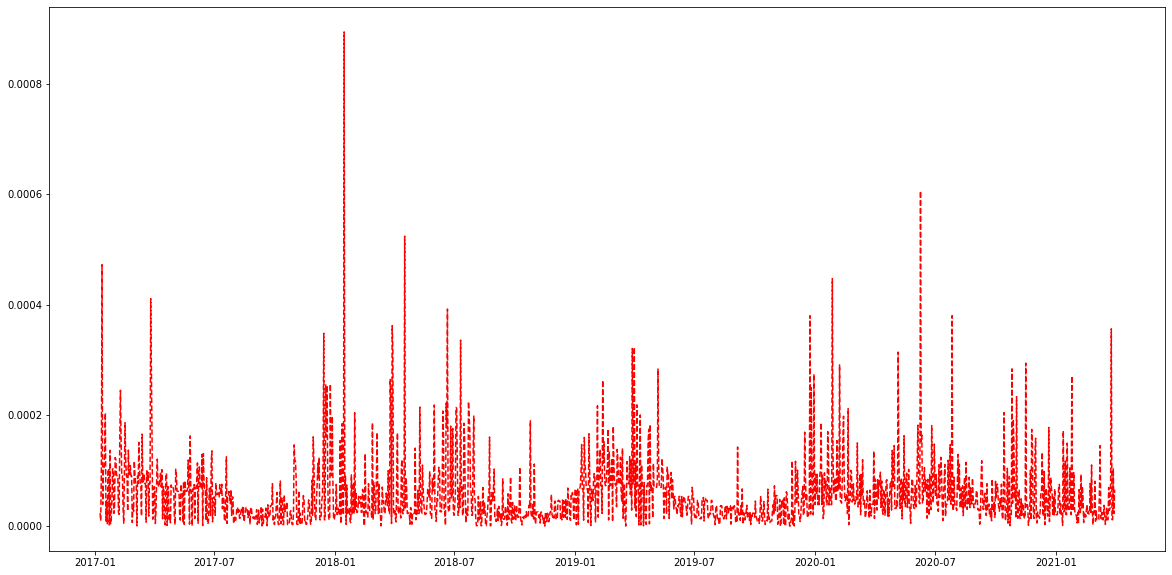

In [77]:
plt.figure(figsize=(20,10))
plt.plot(list(sorted(full_df['date'].unique())), maes, color = 'r', linestyle= '--')

Модель в целом не ухудшается со временем, ее можно дообучать не так часто. Выберем период дообучения - 1 квартал, чтобы добавлять по новых 3 месяца в выборку OOT.

In [112]:
full_df.target.mean() - full_df.target.std()

-0.34087161408409733

In [113]:
alarm_changepoint(full_df)

changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data
changepoint, shift in data


Timestamp('2017-01-11 00:00:00')